# Multilayer Perceptrons (MLP)

In this chapter, we will peel back the curtain, digging deeper into the key components of deep learning computation, namely model construction, parameter access and initialization, designing custom layers and blocks, reading and writing models to disk, and leveraging GPUs to achieve dramatic speedups. These insights will move you from end user to power user, giving you the tools needed to reap the benefits of a mature deep learning library while retaining the flexibility to implement more complex models,


神经网络核心组件


（1）层：神经网络的基本结构，将输入张量转换为输出张量。 (torch.nn.Module)

（2）模型：层构成的网络。 ( torch.nn )

（3）损失函数：参数学习的目标函数，通过最小化损失函数来学习各种参数。 ( torch.nn )

（4）优化器：如何是损失函数最小，这就涉及到优化器。 torch.optim (SGD, ADAM)

nn.functional中函数与nn.Module中的layer的主要区别是后者继承Module类，会自动提取可学习的参数。而nn.functional更像是纯函数。
卷积层、全连接层、dropout层等因含有可学习参数，一般使用nn.Module, 而激活函数、池化层不含可学习参数，可以使用nn.functional中对应的函数。
具体地说：（a）nn.Xxx继承于nn.Module，nn.Xxx 需要先实例化并传入参数，然后以函数调用的方式调用实例化的对象并传入输入数据。它能够很好的与nn.Sequential结合使用，而nn.functional.xxx无法与nn.Sequential结合使用。（b）nn.Xxx不需要自己定义和管理weight、bias参数；而nn.functional.xxx需要你自己定义weight、bias，每次调用的时候都需要手动传入weight、bias等参数, 不利于代码复用。（c）dropout操作在训练和测试阶段是有区别的，使用nn.Xxx方式定义dropout，在调用model.eval()之后，自动实现状态的转换，而使用nn.functional.xxx却无此功能。

总的来说，两种功能都是相同的，但PyTorch官方推荐：具有学习参数的（例如，conv2d, linear, batch_norm)采用nn.Xxx方式。没有学习参数的（例如，maxpool, loss func, activation func）等根据个人选择使用nn.functional.xxx或者nn.Xxx方式。


## (1) model construction: Block Customization 

In [70]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
print(net) # two fully connected layers 

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [71]:
X = torch.rand(2, 20)
net(X)

tensor([[ 0.0702,  0.0195,  0.1349,  0.0683, -0.0030, -0.1124,  0.0219,  0.1841,
         -0.1723, -0.0767],
        [ 0.0824,  0.0140,  0.0429,  0.1698, -0.0395, -0.0374, -0.0501,  0.0598,
         -0.0129, -0.0851]], grad_fn=<AddmmBackward>)

####    MLP Block

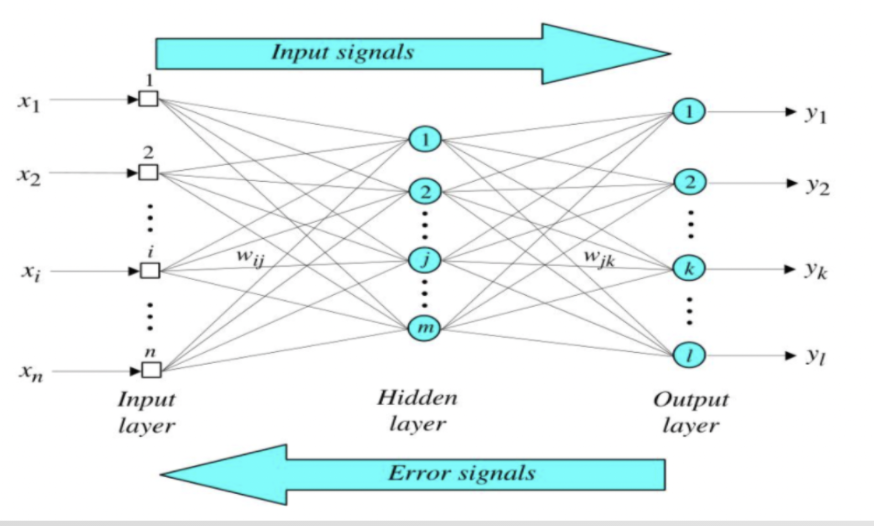

In [73]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters, `params` (to be described later)
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input `X`
    def forward(self, X):
        # Note here we use the funtional version of ReLU defined in the
        # nn.functional module.
        return self.out(F.relu(self.hidden(X)))
    
net = MLP()
net(X)

tensor([[-0.2150, -0.0362,  0.0310,  0.0229, -0.0344, -0.1177, -0.0477, -0.1164,
          0.0251,  0.0742],
        [-0.2160, -0.0288,  0.0534, -0.0367, -0.0856, -0.1625,  0.0098, -0.0043,
          0.0086, -0.1041]], grad_fn=<AddmmBackward>)

#### NOTE:
* First, our customized `__init__` function invokes the parent class's `__init__` function via `super().__init__()` 

* We then instantiate our two fully-connected layers, assigning them to self.hidden and self.out. 

* Note that unless we implement a new operator, we need not worry about the backpropagation function or parameter initialization. The system will generate these functions automatically. 

#### Sequtial Block

In [74]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `Module` subclass. We save it
            # in the member variable `_modules` of the `Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X
    
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)    

# compare: net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))


tensor([[-0.0012, -0.1227, -0.0566, -0.1493,  0.0518, -0.0494, -0.1360, -0.0273,
         -0.0524, -0.2605],
        [-0.0335, -0.2869, -0.0254, -0.0921,  0.0733,  0.0086, -0.1193,  0.0584,
         -0.0860, -0.2449]], grad_fn=<AddmmBackward>)

#### Nested blocks 

In [75]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20))
chimera

Sequential(
  (0): NestMLP(
    (net): Sequential(
      (0): Linear(in_features=20, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (1): Linear(in_features=16, out_features=20, bias=True)
)

In [76]:
chimera(X)

tensor([[-0.0091,  0.0635, -0.1563,  0.0611,  0.1217, -0.0681, -0.2107,  0.2321,
          0.0050, -0.1137,  0.1688,  0.0127,  0.2042, -0.1524,  0.0980, -0.0838,
         -0.0351,  0.3164, -0.2828, -0.3404],
        [-0.0080,  0.0602, -0.1515,  0.0552,  0.1114, -0.0625, -0.1999,  0.2328,
         -0.0105, -0.1164,  0.1717,  0.0118,  0.2142, -0.1758,  0.1075, -0.0872,
         -0.0305,  0.3193, -0.2710, -0.3426]], grad_fn=<AddmmBackward>)

#### Layers without parameters

In [77]:
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [78]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())
Y = net(torch.rand(4, 8))
Y.shape

torch.Size([4, 128])

#### Layers with parameters

In [80]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

linear = MyLinear(5, 3)
#linear.weight
linear(torch.rand(2, 5))

tensor([[0.0000, 0.0338, 0.0000],
        [0.2658, 0.0000, 0.0000]])

In [81]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.],
        [0.]])

## (2) Parameter management 

**We start by focusing on an MLP with one hidden layer.**

In [82]:
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.1184],
        [0.2164]], grad_fn=<AddmmBackward>)

#### Parameter access 

In [30]:
print(net)
print(net[2].state_dict())   # note weights is used as transpose version during calculation 

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
OrderedDict([('weight', tensor([[ 0.2896,  0.2349, -0.2035,  0.1427, -0.0073,  0.2892, -0.1490, -0.2375]])), ('bias', tensor([0.2813]))])


#### Targeted parameters

In [83]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1764], requires_grad=True)
tensor([0.1764])


In [84]:
net[2].weight.grad == None  # Because we have not invoked backpropagation for this network yet, it is in its initial state.

True

#### All parameters at once

In [85]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [88]:
net.state_dict()['2.bias'].data

tensor([0.1764])

#### collecting parameters from nested block

In [89]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 4),
                         nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
print(rgnet)
rgnet(X)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


tensor([[0.3761],
        [0.3760]], grad_fn=<AddmmBackward>)

In [40]:
rgnet[0][1][0].bias.data

tensor([-0.1725, -0.0715, -0.4959,  0.4014, -0.3377,  0.4302,  0.3494, -0.4585])

#### parameter initialization 

In [93]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

net.apply(init_normal)
net[0].weight.shape, net[0].weight.data[0], net[0].bias.data[0],

(torch.Size([8, 4]), tensor([ 0.0145,  0.0069, -0.0044, -0.0041]), tensor(0.))

In [91]:
net[0].bias.data

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [94]:
# customize initialization 
def my_init(m):
    if type(m) == nn.Linear:
        print(
            "Init",
            *[(name, param.shape) for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-6.8927,  0.0000,  6.1977,  0.0000],
        [-5.0331, -0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward>)

In [95]:
net[0].weight.data[:] += 1
print(net[0].weight.data)
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([[-5.8927,  1.0000,  7.1977,  1.0000],
        [-4.0331,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  6.0766,  7.3067],
        [ 1.0000, -8.9779,  1.0000, 10.6895],
        [ 1.0000,  9.6739, -5.5698,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  6.4144],
        [-7.1583, 10.4467,  1.0000, -6.3727],
        [-7.7705,  9.5032,  9.8992,  1.0000]])


tensor([42.0000,  1.0000,  7.1977,  1.0000])

#### Tied parameters 

Often, we want to share parameters across multiple layers.
Let us see how to do this elegantly.
In the following we allocate a dense layer
and then use its parameters specifically
to set those of another layer.


In [96]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), shared, nn.ReLU(), shared,
                    nn.ReLU(), nn.Linear(8, 1))
net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
print(net[4].weight.data[0, 0])

# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor(100.)
tensor([True, True, True, True, True, True, True, True])


In [103]:
# utils 
import time
class Timer: #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """Start the timer."""
        self.tik = time.time()
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)
    def sum(self):
        """Return the sum of time."""
        return sum(self.times)
    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

        
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())  # metric.add(accuracy(net(X), y), len(y))

    return metric[0] / metric[1]

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [104]:
from IPython import display
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import sys, os
import matplotlib.pyplot as plt


### MLP 
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)


sys.path.append(os.getcwd()+'/data')
mypath = sys.path.pop()
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root=mypath, train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root=mypath, train=False, transform=trans, download=True)


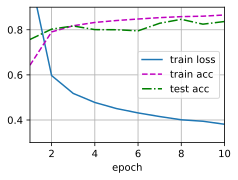

In [106]:
train_iter = data.DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size=256, shuffle=True, num_workers=4)



def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

num_epochs = 10

animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                    legend=['train loss', 'train acc', 'test acc'])

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, trainer)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
    
train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc


#### recall training by logistic regression - softmax 

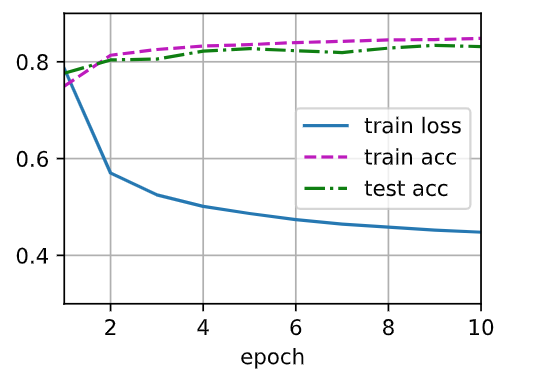